## Exercise 1: Recommender System

In this exercise, we provide you with an implementation of a collaborative-filtering recommender system. Your task is to train the recommender system on the MovieLens dataset with 100k ratings: https://grouplens.org/datasets/movielens/100k/. When you unzip the zip assignment file, the dataset will be in the same directory of your assignment.

Once done training,

1. identify your top-3 favorite movies from the dataset and for each movie, retrieve its top-3 closest movies, and
2. pick three random users from the dataset and get the top-5 recommended movies to them by the the recommender system.

Note that the maxtrix factorization module in the code below is just trying to factorize the rating matrix into submatrices, one which is for the user weights and the other which is for the movies' features (as discussed in class).

### lens dataframe

To make this dataframe, we will need to merge 3 other dataframes that are the following:

1.   users dataframe from u.user file
2.   rating dataframe from u.data file
3.   movies dataframe from u.item file

Note that for all dataframes, use latin-1 as encoding, and make sure to check the appropriate separator for each file


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# users dataframe
# name your columns user_id, age, sex, occupation, and zip_code respectively
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols, encoding='latin-1')

# ratings dataframe
# name your columns user_id, movie_id, rating, and unix_timestamp respectively
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols, encoding='latin-1')

# Reading items file
# name your columns movie_id, title, release_date, video_release_date, and imdb_url respectively
i_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('u.item', sep='|', names=i_cols, usecols=range(5), encoding='latin-1')

# merging data as one dataframe (call it lens)
lens = pd.merge(pd.merge(movies, ratings, on='movie_id'), users, on='user_id')

In [2]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
#visualize your lens dataset
#the header of the dataset should be the following:
#movie_id, title, release_date, video_release_date, imdb_url, user_id, rating, unix_timestamp, age, sex, occupation, zip_code
print(lens.head())

   movie_id                  title release_date  video_release_date  \
0         1       Toy Story (1995)  01-Jan-1995                 NaN   
1         4      Get Shorty (1995)  01-Jan-1995                 NaN   
2         5         Copycat (1995)  01-Jan-1995                 NaN   
3         7  Twelve Monkeys (1995)  01-Jan-1995                 NaN   
4         8            Babe (1995)  01-Jan-1995                 NaN   

                                            imdb_url  user_id  rating  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...      308       4   
1  http://us.imdb.com/M/title-exact?Get%20Shorty%...      308       5   
2  http://us.imdb.com/M/title-exact?Copycat%20(1995)      308       4   
3  http://us.imdb.com/M/title-exact?Twelve%20Monk...      308       4   
4     http://us.imdb.com/M/title-exact?Babe%20(1995)      308       5   

   unix_timestamp  age sex occupation zip_code  
0       887736532   60   M    retired    95076  
1       887737890   60   M    retire

### Pivot table of user_id, movie_id, and rating

The rating matrix is a pivot table that represents user ratings for movies in a numerical format that can help us analyse the recommender systems better.

To make it happen we need to do the following steps:

1. Build series with unique user and movie IDs as index and corresponding numerical indices as values.
2. Map between each unique user and movie ID and their corresponding numerical index.
3. Build the pivot table that has the lens dataframe as data, rating as values, user_inds as index and movie_inds as columns.

In [4]:
# build the user_map series
user_map = pd.Series(index=lens['user_id'].unique(), data=np.arange(lens['user_id'].nunique()))

# build the movie_map series
movie_map = pd.Series(index=lens['movie_id'].unique(), data=np.arange(lens['movie_id'].nunique()))

# mapping unique users ids to the lens data
lens['user_inds'] = lens['user_id'].map(user_map)

# mapping unique movies ids to the lens data
lens['movie_inds'] = lens['movie_id'].map(movie_map)

# make the pivot table and call it rating_matrix
rating_matrix = lens.pivot_table(values='rating', index='user_inds', columns='movie_inds', fill_value=0)

# display the rating matrix
print(rating_matrix.head())

movie_inds  0     1     2     3     4     5     6     7     8     9     ...  \
user_inds                                                               ...   
0              4     5     4     4     5     4     5     5     3     4  ...   
1              5     4     0     0     0     5     5     0     0     0  ...   
2              4     0     0     5     4     0     0     0     0     0  ...   
3              4     3     4     4     5     5     5     5     0     0  ...   
4              3     0     0     3     0     4     0     0     3     0  ...   

movie_inds  1672  1673  1674  1675  1676  1677  1678  1679  1680  1681  
user_inds                                                               
0              0     0     0     0     0     0     0     0     0     0  
1              0     0     0     0     0     0     0     0     0     0  
2              0     0     0     0     0     0     0     0     0     0  
3              0     0     0     0     0     0     0     0     0     0  
4       

### maxtrix factorization module

In [5]:
# MatrixFactorization class
class MatrixFactorization():
    # constructor
    def __init__(self, rating_matrix, rating_matrix_val, k=5, lmbda=0.01, max_epochs=50, lr=0.1):
        '''
        rating_matrix: the matrix of rating (row: user, col: movie)
        k : int, default=2
            Number of latent features
        lmbda : float, default=0.01
            Regularization parameter
        max_epochs : int, default=15
            Max number of iterations to run
        lr: float, default:0.1
            Learning rate
        '''
        self.rating_matrix = rating_matrix
        self.rating_matrix_val = rating_matrix_val
        self.k = k
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.lr = lr
        self.U = np.random.normal(scale=1./self.k, size=(rating_matrix.shape[0], self.k))
        self.V = np.random.normal(scale=1./self.k, size=(self.k, rating_matrix.shape[1]))
        self.b_u = np.zeros(rating_matrix.shape[0])
        self.b_i = np.zeros(rating_matrix.shape[1])
        self.b = np.mean(rating_matrix[np.where(rating_matrix != 0)])
        self.mean_squared_errors = []
        self.mean_squared_errors_val = []
    # fitting the model
    def fit(self):
        for it in range(self.max_epochs):
            for i in range(len(self.rating_matrix)):
                for j in range(len(self.rating_matrix[i])):
                    if self.rating_matrix[i][j] > 0:
                        eij = self.rating_matrix[i][j] - (self.predict_rating_user_movie(i, j))
                        self.b_u[i] += self.lr * (eij - self.lmbda * self.b_u[i])
                        self.b_i[j] += self.lr * (eij - self.lmbda * self.b_i[j])
                        self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
                        self.V[:,j] += self.lr * (eij * self.U[i,:] - self.lmbda * self.V[:,j])

            self.mean_squared_errors.append(self.mse_training(self.rating_matrix, self.predict()))
            self.mean_squared_errors_val.append(self.mse_validation(self.rating_matrix, self.rating_matrix_val, self.predict()))

    # reporting model's mse using the training set
    def mse_training(self, true_rating, pred_rating):
        '''
        pred_matrix: the predict matrix of rating (row: user, col: movie)
        return: mean squared error
        '''
        error = 0
        for rt, rp in zip(true_rating, pred_rating):
            for vt, vp in zip(rt, rp):
                if vt > 0:
                    error += pow(vt - vp, 2)
        return np.sqrt(error)

    # reporting model's mse using testing set
    def mse_validation(self, true_rating, test_rating, pred_rating):
        '''
        pred_matrix: the predict matrix of rating (row: user, col: movie)
        return: mean squared error
        '''
        error = 0
        for rt, rtt, rp in zip(true_rating, test_rating, pred_rating):
            for vt, vtt, vp in zip(rt, rtt, rp):
                if vt == -1:
                    error += pow(vtt - vp, 2)
        return np.sqrt(error)

    # predicting the user's movie rating
    def predict_rating_user_movie(self, i, j):
        '''
        i: user row
        j: movie col
        '''
        return self.b + self.b_u[i] + self.b_i[j] + np.dot(self.U[i,:],self.V[:,j])

    # rating prediction
    def predict(self):
        '''
        return: rating prediction
        '''
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:, ] + np.dot(self.U, self.V)

    # plotting model's loss
    def plot_loss(self):
        iters = [i for i in range(self.max_epochs)]
        plt.xlabel("Iterations")
        plt.ylabel("Mean Squared Error")
        plt.plot(iters, self.mean_squared_errors)
        plt.plot(iters, self.mean_squared_errors_val)

    # mean square error result
    def mse_result(self):
        return self.mean_squared_errors[-1]



In [6]:
# splitting data into train and validation sets
def create_training_validation_set(rating_matrix):
    r_test = rating_matrix.copy()
    r_train = rating_matrix.copy()

    for r in range(0,r_train.shape[0]):
        for c in range(0, r_train.shape[1]):
            if np.random.rand() < 0.2 and r_train.iloc[r, c] != 0:
                r_train.iloc[r, c] = -1

    return np.asarray(r_train), r_test

rating_matrix_training, rating_matrix_validation = create_training_validation_set(rating_matrix)

rating_matrix_training = np.array(rating_matrix_training)
rating_matrix_validation = np.array(rating_matrix_validation)

In [7]:
rating_matrix_training

array([[ 4,  5, -1, ...,  0,  0,  0],
       [ 5,  4,  0, ...,  0,  0,  0],
       [ 4,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [8]:
rating_matrix_validation

array([[4, 5, 4, ..., 0, 0, 0],
       [5, 4, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
# finding top movies
def find_top_close_movies(movie_idx, idx_movie, pred_rating, movie_name):
    movie_to_check = pred_rating[:, movie_idx[movie_name]] # 'Star Wars (1977)'
    df1 = pd.DataFrame(pred_rating)
    df2 = pd.DataFrame(movie_to_check)
    df = df1.corrwith(df2[0], axis=0)
    results = df.sort_values(ascending=False).head(4)[1:]
    for i, j in zip(list(results.index), results.values):
        print(idx_movie[i], j)

In [10]:
# recommending movies
def recommend_movies_to_user(idx_movie, pred_rating, user_id):
    user_to_check = pred_rating[user_id, :]
    df1 = pd.DataFrame(pred_rating)
    df2 = pd.DataFrame(user_to_check)
    df = df1.corrwith(df2[0], axis=1)
    results = df.sort_values(ascending=False).head(6)[1:]

    movie_index = []
    for i in results.index:
        movie_index.append(pred_rating[i,:])

    movie_index = np.asarray(movie_index)

    movie_index = np.mean(movie_index, axis=0)

    results = pd.DataFrame(movie_index).sort_values(by=0, ascending=False).head(5)

    for i, j in zip(list(results.index), results.values):

        if user_to_check[i]:
            try:
                print(idx_movie[i])
            except Exception as e:
                pass

## Tune the hyperparameters

You have to implement your own GridSerch method to tune the model  hyperparameters:

1. k (number of latent features and weights)
2. lmbda (regularization)
3. max_epochs
4. lr (learning rate).

You should then report  the training and the validation mean squared errors and plot the loss of your best model. Code snippets for doing each task are given below.  

In [28]:
def grid_search(parameter_combinations, rating_matrix_train, rating_matrix_val):
    # choose the minimum mse = 1000
    min_mse = 1000
    # make a empty array that will hold later on your best parameters
    best_params = None

    # loop over all parameters that are passed through the grid_search function
    for params in parameter_combinations:
        # make your model with all the parameters
        k, lmbda, max_epochs, lr = params

        # initialize the MatrixFactorization model with the current set of parameters
        model = MatrixFactorization(rating_matrix_train, rating_matrix_val, k, lmbda, max_epochs, lr)
        
        # fit model
        model.fit()
        
        # predict labels
        predicted_ratings = model.predict()
        
        # measure mse
        mse_val = model.mse_validation(rating_matrix_train, rating_matrix_val, predicted_ratings)  # This line assumes you have such a method

        # find the best parameters with the minimum mse and update your empty array
        if mse_val < min_mse:
            min_mse = mse_val
            best_params = {'k': k, 'lmbda': lmbda, 'max_epochs': max_epochs, 'lr': lr}

    #print the minimum mse
    print(f"Minimum Validation MSE: {min_mse}")
    #return the parameters
    return best_params

In [29]:
# import itertools
import itertools

# input your parameters
k_values = [20, 50, 100]  # number of latent features
lambda_values = [0.01, 0.1, 1.0]  # regularization strengths
max_epochs_values = [20, 50, 100]  # number of training epochs
lr_values = [0.01, 0.05, 0.1]  # learning rates

# merge all parameters in one list
parameters = [k_values, lambda_values, max_epochs_values, lr_values]
parameter_combinations = list(itertools.product(*parameters))

# run the grid search
best_hyperparameters = grid_search(parameter_combinations, rating_matrix_training, rating_matrix_validation)

C:\Users\osama\AppData\Local\Temp\ipykernel_31788\334228030.py:39: RuntimeWarning: overflow encountered in multiply
  self.V[:,j] += self.lr * (eij * self.U[i,:] - self.lmbda * self.V[:,j])
C:\Users\osama\AppData\Local\Temp\ipykernel_31788\334228030.py:38: RuntimeWarning: overflow encountered in multiply
  self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
C:\Users\osama\AppData\Local\Temp\ipykernel_31788\334228030.py:38: RuntimeWarning: invalid value encountered in add
  self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
C:\Users\osama\AppData\Local\Temp\ipykernel_31788\334228030.py:54: RuntimeWarning: overflow encountered in scalar power
  error += pow(vt - vp, 2)
C:\Users\osama\AppData\Local\Temp\ipykernel_31788\334228030.py:67: RuntimeWarning: overflow encountered in scalar power
  error += pow(vtt - vp, 2)
C:\Users\osama\AppData\Local\Temp\ipykernel_31788\334228030.py:39: RuntimeWarning: invalid value encountered in subtract
  self.V[:,j] 

Minimum Validation MSE: 128.26924286992767


In [13]:
# print the best parameters
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'k': 100, 'lmbda': 0.01, 'max_epochs': 100, 'lr': 0.05}


In [14]:
# pass the best parameters to MatrixFactorization model
best_parameters = {
    'k': 50,
    'lmbda': 0.1,
    'max_epochs': 100,
    'lr': 0.05
}

# instantiate the MatrixFactorization model with the best parameters
model = MatrixFactorization(
    rating_matrix=rating_matrix_training, 
    rating_matrix_val=rating_matrix_validation, 
    k=best_parameters['k'], 
    lmbda=best_parameters['lmbda'], 
    max_epochs=best_parameters['max_epochs'], 
    lr=best_parameters['lr']
)

# fit model
model.fit()

# predict labels
predicted_ratings = model.predict()

# report best model mse score
validation_mse = model.mse_validation(rating_matrix_training, rating_matrix_validation, predicted_ratings)
print(f"The MSE of the best model on the validation set is: {validation_mse}")

The MSE of the best model on the validation set is: 132.9357004626601


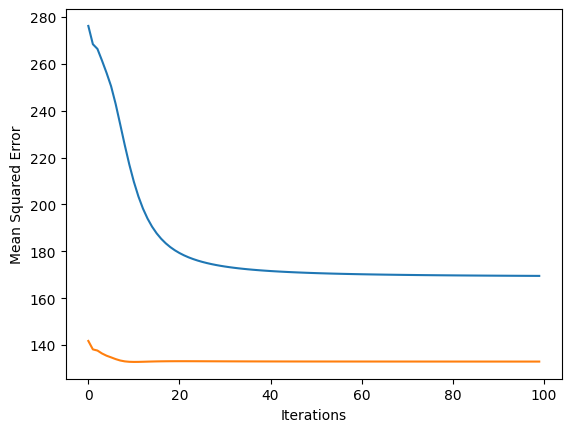

In [15]:
# plot the model loss
model.plot_loss()

In [16]:
# report the best model mse_results

# hypterparameters to be used
hyperparameters = [
    {'k': 20, 'lmbda': 0.01, 'max_epochs': 20, 'lr': 0.01},
    {'k': 50, 'lmbda': 0.1, 'max_epochs': 100, 'lr': 0.05},
]

# initialize list to store models and their MSEs
models_mse = []

# iterate over all hyperparameter combinations
for params in hyperparameters:
    # instantiate the MatrixFactorization model with current parameters
    model = MatrixFactorization(
        rating_matrix=rating_matrix_training, 
        rating_matrix_val=rating_matrix_validation, 
        k=params['k'], 
        lmbda=params['lmbda'], 
        max_epochs=params['max_epochs'], 
        lr=params['lr']
    )

    # fit the model
    model.fit()

    # predict ratings using the model's predict method
    predicted_ratings = model.predict()

    # calculate the MSE using the model's validation method
    validation_mse = model.mse_validation(rating_matrix_training, rating_matrix_validation, predicted_ratings)

    # store the model, its validation MSE, and parameters
    models_mse.append((model, validation_mse, params))

# identify the model with the lowest MSE on the validation set
best_model, best_validation_mse, best_params = min(models_mse, key=lambda x: x[1])

# extract best parameters for easy access
best_k = best_params['k']
best_lmbda = best_params['lmbda']
best_max_epochs = best_params['max_epochs']
best_lr = best_params['lr']

# report the MSE of the best model and its parameters
print(f"The best model has a validation MSE of: {best_validation_mse}")
print(f"Best number of latent factors: {best_k}")
print(f"Best regularization term: {best_lmbda}")
print(f"Best number of epochs: {best_max_epochs}")
print(f"Best learning rate: {best_lr}")

The best model has a validation MSE of: 132.92723357335188
Best number of latent factors: 50
Best regularization term: 0.1
Best number of epochs: 100
Best learning rate: 0.05


## Choose a Movie

In [17]:
#find a top movie

movie_idx = {row['title']: row['movie_id'] for index, row in movies.iterrows()}
idx_movie = {row['movie_id']: row['title'] for index, row in movies.iterrows()}

favorite_movie = "Copycat (1995)"
find_top_close_movies(movie_idx, idx_movie, predicted_ratings, favorite_movie)

Audrey Rose (1977) 0.8219341919316474
Loaded (1994) 0.8192594554641126
Graduate, The (1967) 0.8092684491763646


C:\Users\osama\AppData\Local\Temp\ipykernel_31788\574110001.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  results = df.sort_values(ascending=False).head(4)[1:]


## Choose randomly a user id

In [19]:
#recommend movies to user
user_id = 196
recommend_movies_to_user(idx_movie, predicted_ratings, user_id)

That Old Feeling (1997)
Empire Strikes Back, The (1980)
Pete's Dragon (1977)
Usual Suspects, The (1995)
Scarlet Letter, The (1995)


C:\Users\osama\AppData\Local\Temp\ipykernel_31788\4172052617.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  results = df.sort_values(ascending=False).head(6)[1:]


## Exercise 2: Clustering

In this assignment you will run k-means clustering and PCA on a dataset of reviews of points of interests (POIs) on TripAdvisor. The dataset tripadvisor_review.csv consists of traveler's reviews on POIs in East Asia from 10 different categories (beaches, monuments, churches, venues, etc.). Each traveler rating is mapped into a 5-point scale as follows: Excellent(4), Very Good(3), Average(2), Poor(1), and Terrible(0).

Your tasks are the following:
1. Run k-means clustering on the TripAdvisor dataset provided using the Euclidean distance as a distance metric.
2. Vary the number of clusters K from 2 to 10.
3. Plot the clustering cost (i.e., inertia) against the number of clusters K.
4. Report the value of K you could deduce from  your plot (if any).

Make sure you do multiple runs of the algorithm with different initializations to ensure that you don’t get stuck in a local optimum.

### Loading the data

In [2]:
from sklearn.cluster import KMeans
import matplotlib
# loading data
data = pd.read_csv('tripadvisor_review.csv')

# load the features in X
X = data.iloc[:, 1:]

# visualize the first 2 records of X
print(X.head(2))

   Category 1  Category 2  Category 3  Category 4  Category 5  Category 6  \
0        0.93         1.8        2.29        0.62        0.80        2.42   
1        1.02         2.2        2.66        0.64        1.42        3.18   

   Category 7  Category 8  Category 9  Category 10  
0        3.19        2.79        1.82         2.42  
1        3.21        2.63        1.86         2.32  


### Build the plot based on the model's output

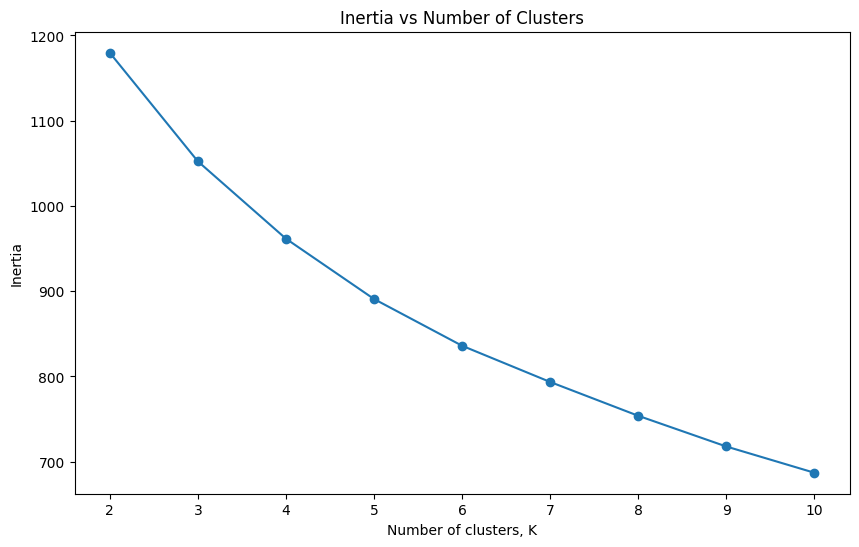

In [3]:
#NOTE: To show the elbow method point, start the range from 1 to 11 rather than 2 to 11

#make an array of all needed values of k
ks = range(2, 11)

#make an empty array to store the inertias
inertias = []

#look over each value of k
for k in ks:

    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    # fit model to X
    model.fit(X)
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

#plot the plot
plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, '-o')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

## Exercise 3: PCA

Run Principal Component Analysis (PCA) on the TripAdvisor dataset and project the data into the first two principal components. Plot the dataset by projecting it on these two components and color the travlers based on their best cluster labels from exercise 1.

In [4]:
from sklearn.decomposition import PCA
import matplotlib
import seaborn as sns

# create a PCA instance: pca with 2 principal components
pca = PCA(n_components=2)

# Fit the PCA instance to the data and transform the data to its principal components
pca_result = pca.fit_transform(X)

# save components to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['Component 1', 'Component 2'])

# Rename the columns of the DataFrame to 'Component1' and 'Component2'
pca_df.columns = ['Component 1', 'Component 2']

Now, you need to rebuild your model taking into consideration the pca that you have just done

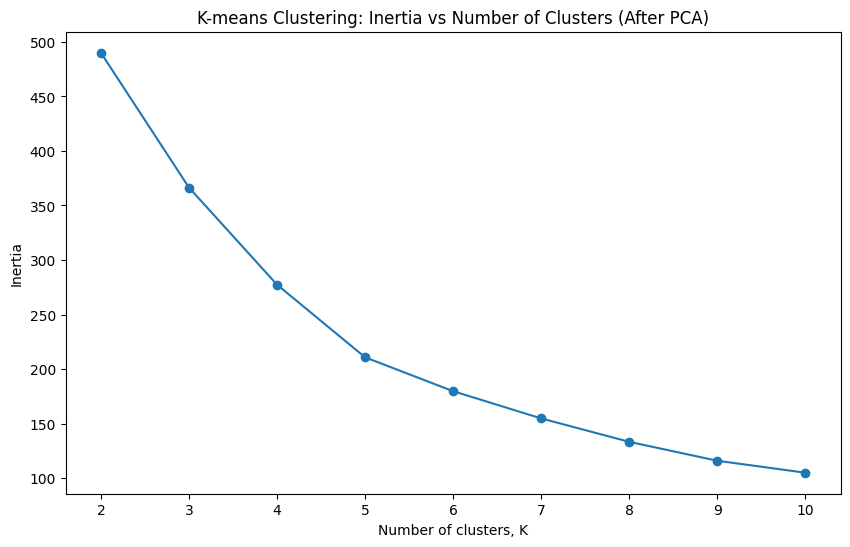

In [5]:
#make an array of all needed values of k
ks = range(2, 11)

#make an empty array to store the inertias
inertias = []

#look over each value of k
for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    # fit model to samples
    model.fit(pca_df)
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
#plot the graph
plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, '-o')
plt.title('K-means Clustering: Inertia vs Number of Clusters (After PCA)')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

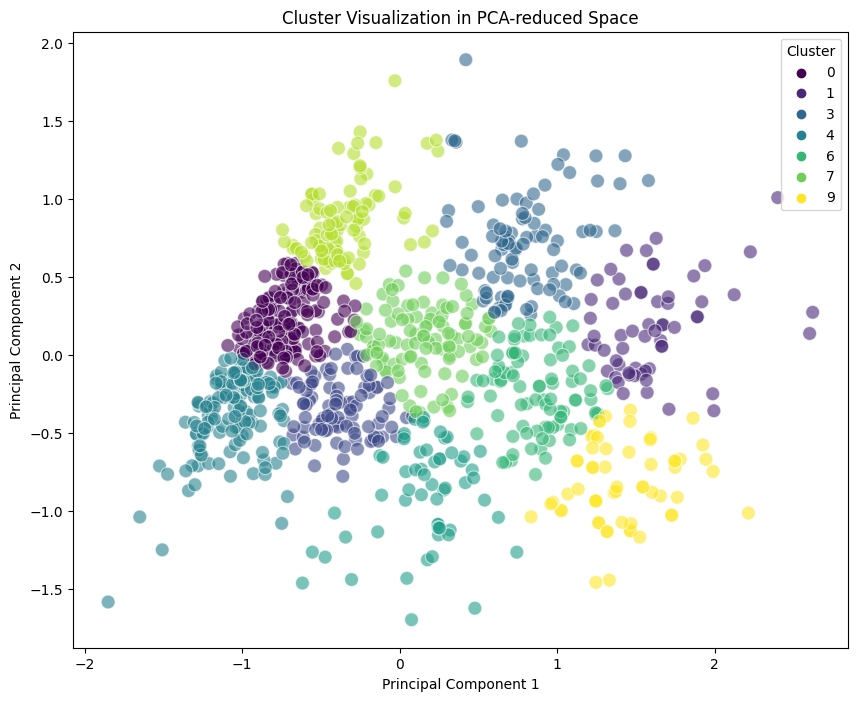

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate KMeans with the best number of clusters determined previously
k_best = 10
kmeans = KMeans(n_clusters=k_best, random_state=42)

# Fit KMeans to the PCA components
kmeans.fit(pca_df)

# Assign cluster labels to the DataFrame
pca_df['Cluster'] = kmeans.labels_
data['Cluster'] = kmeans.labels_

# Concatenate the original data with the PCA components
full_df = pd.concat([data, pca_df], axis=1)

# plots Axes
plt.figure(figsize=(10, 8))

# cluster plotting (use scatter plot)
sns.scatterplot(x='Component 1', y='Component 2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.6)
plt.title('Cluster Visualization in PCA-reduced Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()